# Instance metrics

Tree properties:
- depth
- max width
- number of leaf nodes

Tree hyperparameters:
- minsplit
- minbucket

Tree metrics:
- variable importance

Metrics:
- average path length
- RAK (rooted at k)
- mean rank
- average distinct features per path
- co-occurrence matrix
- entropy (to be implemented)

Experiments:
- depth and average path length
- maxwidth and average path length
- variable importance and mean rank
- variable importance and RAK

In [115]:
import json
import pandas as pd
import re
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statistics import mean, variance, stdev
from scipy.stats.stats import pearsonr

sys.path.append('/Users/nayana/projects/Project/kitchen/experiments')
from PythonScripts.instance_metrics import InstanceMetrics

## Load data

### Dataset

In [116]:
# dataset: iris, adult, auto

dataset = 'iris'

with open('../Configs/'+dataset+'.json') as config_file:
        config = json.load(config_file)

dataset = pd.read_csv('../Data/'+config['filtered_data_with_headers'], header = 0)

dataset = dataset.values[0:config['sample']]
X = dataset[:,0:config['num_features']]
labels = dataset[:,config['target_col']-1]

features = np.arange(1,config['num_features']+1)

### Paths

In [117]:
primary_paths = pd.read_csv('../Outputs/'+config['primary_paths'], header = 0)
secondary_paths = pd.read_csv('../Outputs/'+config['secondary_paths'], header = 0, index_col=0)
bins = pd.read_csv('../Outputs/'+config['local_bins'], header = 0)

primary_paths = primary_paths.values
secondary_paths = secondary_paths.values

bin_vals = bins.values
bin_dict = dict((x[0], x[1]) for x in bin_vals)

regex = re.compile(config['path_regex'], re.I)

### Depths

In [118]:
depths = pd.read_csv('../Outputs/'+config['tree_depths'], header = 0)

depths = depths.values
depths = depths.flatten()
print(len(depths))

150


### Leaf nodes

In [119]:
leaf_nodes = pd.read_csv('../Outputs/'+config['leaf_nodes'], header = 0)
num_leaves = leaf_nodes[['num_leaves']].values.flatten()

### Tree widths

In [120]:
tree_widths = pd.read_csv('../Outputs/'+config['tree_widths'], header = 0)
widths = tree_widths[['width']].values.flatten()

### Variable Importance

In [121]:
variable_importance = pd.read_csv('../Outputs/'+config['variable_importance'], header = 0)

### Lists

In [122]:
average_dist_feat = []
average_path_lengths = []
mean_ranks = []
depth_frequency = []

ratio_depth_avgpathlen = []
ratio_maxwidth_avgpathlen = []

## Compute metrics

In [123]:
for i in range(config['sample']):

    inst = i

    # GET PATHS

    path_list = []

    paths_i = secondary_paths[:,inst]
    if len(np.argwhere(pd.isnull(paths_i)))>0:
        paths_i = paths_i[:np.argwhere(pd.isnull(paths_i))[0][0]]
    np.insert(paths_i, 0, primary_paths[inst], axis=0)

    for path in paths_i:
        nodes = path.split(",")
        newpath = []
        for node in nodes:
            matchobj =  re.match(regex, node)
            newpath.append((int(matchobj.group(1)), bin_dict[matchobj.group(2)], matchobj.group(3)))
        path_list.append(newpath)

    # WEIGHTS

    weights = np.repeat(config['secondary_weight'], len(paths_i)-1)
    weights = np.insert(weights, 0, config['primary_weight'], axis=0)

    metrics = InstanceMetrics(inst, X[inst,:], path_list, weights, labels[inst], features, depths)

    # APPEND TO LIST
    average_dist_feat.append(metrics.avg_distinct_features())
    average_path_lengths.append(metrics.average_path_length())
    mean_ranks.append(metrics.mean_rank())
    depth_frequency.append(metrics.frequency_at_all_depths())
    
    ratio_depth_avgpathlen.append(depths[inst]/metrics.average_path_length())
    ratio_maxwidth_avgpathlen.append(widths[inst]/metrics.average_path_length())

## Distributions of metrics

#### Distinct features

In [124]:
print("Mean:",mean(average_dist_feat))
print("Variance:",variance(average_dist_feat))
print("Standard deviation:",stdev(average_dist_feat))
print("Min, max:",min(average_dist_feat), max(average_dist_feat))

Mean: 1.4727444021896687
Variance: 0.05523821233816004
Standard deviation: 0.23502810967660878
Min, max: 1.2558139534883723 2.4020618556701


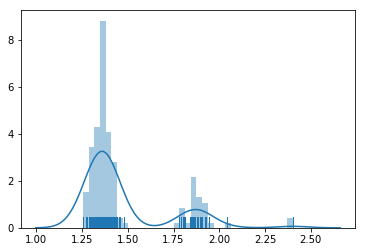

In [125]:
sns.distplot(average_dist_feat, hist=True, rug=True)

#### Depths

In [126]:
print("Mean:",np.mean(depths))
print("Variance:",np.var(depths))
print("Standard deviation:",np.std(depths))
print("Min, max:",min(depths), max(depths))

Mean: 3.26
Variance: 0.9257333333333334
Standard deviation: 0.9621503693983251
Min, max: 2 6


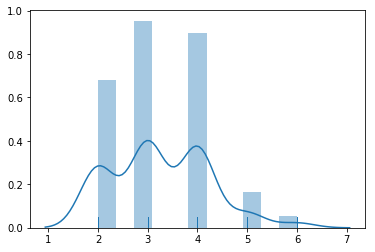

In [127]:
sns.distplot(depths, hist=True, rug=True)

#### Path lengths

In [128]:
print("Mean:",np.mean(average_path_lengths))
print("Variance:",np.var(average_path_lengths))
print("Standard deviation:",np.std(average_path_lengths))
print("Min, max:",min(depths), max(average_path_lengths))

Mean: 2.2826985204847596
Variance: 0.05936511515891218
Standard deviation: 0.2436495745100167
Min, max: 2 4.309278350515457


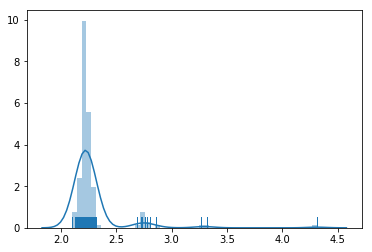

In [129]:
sns.distplot(average_path_lengths, hist=True, rug=True)

## Rough experiments

In [130]:
pearsonr(depths, average_path_lengths)

(0.107040733461009, 0.1923160653131968)

In [131]:
pearsonr(depths, average_dist_feat)

(-0.012451478339485449, 0.8797950915617433)

In [132]:
pearsonr(widths, average_path_lengths)

(-0.040603383834763446, 0.6217784851193636)

In [133]:
pearsonr(widths, average_dist_feat)

(-0.022641828386712116, 0.783300786087001)

In [134]:
pearsonr(num_leaves, average_path_lengths)

(0.05171033502290111, 0.5297142251840693)

In [135]:
pearsonr(num_leaves, average_dist_feat)

(-0.04541997772160112, 0.5810098290100479)

## Experiments

#### Depth to average path length

In [136]:
print("Mean:",mean(ratio_depth_avgpathlen))
print("Variance:",variance(ratio_depth_avgpathlen))
print("Standard deviation:",stdev(ratio_depth_avgpathlen))
print("Min, max:", min(ratio_depth_avgpathlen), max(ratio_depth_avgpathlen))

Mean: 1.4351298901518894
Variance: 0.18564575262326805
Standard deviation: 0.4308662816040123
Min, max: 0.6961722488038289 2.7649769585253456


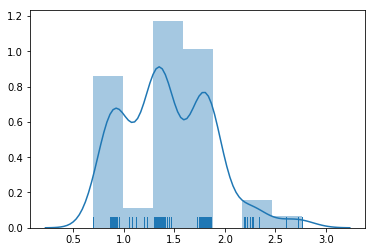

In [137]:
sns.distplot(ratio_depth_avgpathlen, hist=True, rug=True)

In [138]:
pearsonr(average_path_lengths, depths)

(0.107040733461009, 0.1923160653131968)

#### Max width to average path length

In [139]:
print("Mean:",np.mean(ratio_maxwidth_avgpathlen))
print("Variance:",np.var(ratio_maxwidth_avgpathlen))
print("Standard deviation:",np.std(ratio_maxwidth_avgpathlen))
print("Min, max:", min(ratio_maxwidth_avgpathlen), max(ratio_maxwidth_avgpathlen))

Mean: 1.183954933156629
Variance: 0.1846838349456805
Standard deviation: 0.4297485717785232
Min, max: 0.464114832535886 1.8762886597938144


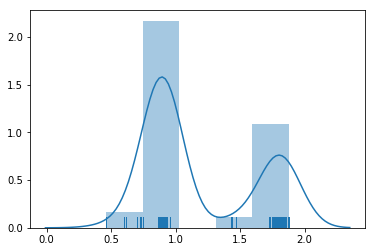

In [140]:
sns.distplot(ratio_maxwidth_avgpathlen, hist=True, rug=True)

In [141]:
pearsonr(widths, average_path_lengths)

(-0.040603383834763446, 0.6217784851193636)

#### Variable importance and mean rank

Estimate mean rank using variable importance from trees

normalized mean rank = c x normalized variable importance, c $\approx$ 1

In [142]:
mean_rank_across_instances = np.mean(mean_ranks, axis = 0)
mean_rank_across_instances_norm = [float(i)/sum(mean_rank_across_instances) for i in mean_rank_across_instances]
variable_importance_across_instances = np.mean(variable_importance, axis = 0)
variable_importance_across_instances_norm = [
    float(i)/sum(variable_importance_across_instances) for i in variable_importance_across_instances]

In [143]:
ratio_meanrank_variableimp_norm = [
    x/y for x,y in zip(variable_importance_across_instances_norm, mean_rank_across_instances_norm)]
ratio_meanrank_variableimp = [
    x/y for x,y in zip(variable_importance_across_instances, mean_rank_across_instances)]

In [144]:
pearsonr(mean_rank_across_instances, variable_importance_across_instances)

(0.665035105223575, 0.334964894776425)

In [145]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [150]:
mean(reject_outliers(np.array(ratio_meanrank_variableimp_norm)))

5.61278671875774

#### Variable importance and RAK

Estimate RAK from variable importance

In [147]:
depth_frequency_across_instances = []
for depth in range(min(depths)+1): # +1?
    depth_i_frequency = [item[depth] for item in depth_frequency]
    depth_frequency_across_instances.append(np.mean(depth_i_frequency, axis = 0))

In [148]:
for i in range(len(depth_frequency_across_instances)):
    print(i, pearsonr(depth_frequency_across_instances[i], variable_importance_across_instances))

0 (0.5921747442369388, 0.40782525576306117)
1 (0.7280273285724246, 0.2719726714275754)
2 (0.8961785070401914, 0.10382149295980858)
